<!-- Implement the Continuous Bag of Words (CBOW) Model. Stages can be: -->

# Import Libraries 

In [1]:
import numpy as np  # Importing NumPy for numerical operations

import re  # Importing regular expressions for text cleaning

import tensorflow as tf  # Importing TensorFlow for building neural networks

from tensorflow.keras.models import Sequential  # Sequential model for stacking layers in Keras

from tensorflow.keras.layers import Dense, Embedding, Lambda  # Importing layers: Dense, Embedding, and Lambda
# Dense: Fully connected layer, Embedding: For text input conversion to dense vectors, Lambda: Custom operations

from tensorflow.keras.preprocessing.text import Tokenizer  # Tokenizer for converting text into integer sequences


In [2]:
data = "Deep learning (also known as deep structured learning) is part of a broader family of machine learning methods based on artificial neural networks with representation   learning. Learning can be supervised, semi-supervised or unsupervised. Deep-learning architectures such as deep neural networks, deep belief networks, deep reinforcement learning, recurrent neural networks, convolutional neural networks and Transformers have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image analysis, climate science, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance."
data



'Deep learning (also known as deep structured learning) is part of a broader family of machine learning methods based on artificial neural networks with representation   learning. Learning can be supervised, semi-supervised or unsupervised. Deep-learning architectures such as deep neural networks, deep belief networks, deep reinforcement learning, recurrent neural networks, convolutional neural networks and Transformers have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image analysis, climate science, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance.'

# Split into sentences


In [3]:
sentences = data.split('.')  # Splitting the text 'data' into sentences based on the period ('.') delimiter

sentences = [sentence for sentence in sentences if sentence.strip()]  
# List comprehension to remove any empty or whitespace-only sentences from the 'sentences' list


# Clean Data of Special Characters


In [4]:
clean_sent = []  # Initialize an empty list to store the cleaned sentences

# Loop over each sentence in the list 'sentences'
for sentence in sentences:
    sentence = re.sub('[^A-Za-z0-9]+', ' ', sentence)  
    # Remove all characters except alphanumeric ones (A-Z, a-z, 0-9), replacing them with a space
    
    sentence = re.sub(r'(?:^| )\\w (?:$| )', ' ', sentence).strip()  
    # Remove single characters (e.g., single-letter words), and strip leading/trailing whitespaces

    sentence = sentence.lower()  # Convert the sentence to lowercase
    
    clean_sent.append(sentence)  # Append the cleaned sentence to the list 'clean_sent'


# Tokenization


In [5]:
tokenizer = Tokenizer()  # Initialize the Tokenizer object from Keras

tokenizer.fit_on_texts(clean_sent)  
# Fit the tokenizer on the cleaned sentences ('clean_sent') to create a vocabulary of word indices 
# (each unique word gets a unique integer)

sequences = tokenizer.texts_to_sequences(clean_sent)  
# Convert each sentence in 'clean_sent' into a sequence of integers, 
# where each word is represented by its corresponding index from the vocabulary


# Create dictionaries for word lookup


In [6]:
index_to_word = {}  # Initialize an empty dictionary to map indices to words

word_to_index = {}  # Initialize an empty dictionary to map words to indices


In [7]:
for i, sequence in enumerate(sequences):  # Loop through each sentence (sequence) in the 'sequences' list
    word_in_sentence = clean_sent[i].split()  # Split the cleaned sentence into words (tokens)
    
    for j, value in enumerate(sequence):  # Loop through each word index in the 'sequence'
        index_to_word[value] = word_in_sentence[j]  # Map the index to the corresponding word in the sentence
        word_to_index[word_in_sentence[j]] = value  # Map the word to its corresponding index


# Create dictionaries to map between word and integer IDs


In [8]:
vocab_size = len(tokenizer.word_index) + 1  # Calculate the vocabulary size by counting the words in the tokenizer's word index, adding 1 for padding (index 0 is often reserved for padding)
emb_size = 100  # Set the embedding size (the dimensionality of the word vectors; 100 is a common choice)
context_size = 2  # Set the context size (the window size for the context words around the target word in Word2Vec-like models)


# Create contexts and targets for CBOW model


In [9]:
contexts = []  # Initialize an empty list to store context words
targets = []   # Initialize an empty list to store target words

# Loop through each sequence (sentence) in the list of sequences
for sequence in sequences:
    # Loop through each word in the sequence, skipping the first and last word
    for i in range(1, len(sequence) - 1):
        # Check if the current position has valid context words within the specified context size
        if i - context_size >= 0 and i + context_size < len(sequence):
            target = sequence[i]  # Set the target word as the current word (center of context window)
            context = [sequence[i - context_size], sequence[i + context_size]]  
            # Select the words at 'context_size' distance on either side of the target
            
            contexts.append(context)  # Append the context pair to the 'contexts' list
            targets.append(target)    # Append the target word to the 'targets' list


# Convert contexts and targets to NumPy arrays


In [10]:
X = np.array(contexts)  # Convert the list of context word pairs into a NumPy array for efficient processing
Y = np.array(targets)   # Convert the list of target words into a NumPy array for efficient processing


# Define the CBOW model architecture


In [11]:
model = Sequential([  
    # Initialize a sequential model, allowing layers to be added in a sequence

    Embedding(input_dim=vocab_size, output_dim=emb_size),  
    # Embedding layer: converts each word index in the input into a dense vector of fixed size (emb_size)
    # input_dim: The vocabulary size, i.e., the number of unique words
    # output_dim: The size of each embedding vector (e.g., 100 for emb_size)
    
    Lambda(lambda x: tf.reduce_mean(x, axis=1)),  
    # Lambda layer: Applies a custom function, here using 'reduce_mean' to compute the average of the embeddings
    # This averages the embeddings across the context words to produce a single representation
    
    Dense(256, activation='relu'),  
    # Dense layer with 256 neurons and ReLU activation function
    # Adds a non-linear transformation to learn complex patterns in the input embeddings
    
    Dense(vocab_size, activation='softmax')  
    # Output layer with softmax activation function and 'vocab_size' neurons
    # Softmax provides probabilities for each word in the vocabulary, predicting the target word
])


# Compile the model


In [12]:
model.compile(
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification with integer labels
    optimizer='adam',  # Optimizer that adapts the learning rate for efficient training
    metrics=['accuracy']  # Metric to evaluate the model’s performance during training
)


# Train the model


In [13]:
history = model.fit(
    X, Y,  # Training data (X as input contexts, Y as target words)
    epochs=100,  # Number of times the model will go through the entire training dataset
    batch_size=32  # Number of samples processed before updating the model’s internal parameters
)


Epoch 1/100


3/3 [==============================] - 3s 37ms/step - loss: 4.3168 - accuracy: 0.0227
Epoch 2/100
3/3 [==============================] - 0s 7ms/step - loss: 4.2975 - accuracy: 0.1250
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 4.2810 - accuracy: 0.3068
Epoch 4/100
3/3 [==============================] - 0s 6ms/step - loss: 4.2646 - accuracy: 0.3409
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 4.2464 - accuracy: 0.3864
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 4.2269 - accuracy: 0.3977
Epoch 7/100
3/3 [==============================] - 0s 8ms/step - loss: 4.2046 - accuracy: 0.4091
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 4.1799 - accuracy: 0.3977
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 4.1514 - accuracy: 0.3864
Epoch 10/100
3/3 [==============================] - 0s 8ms/step - loss: 4.1206 - accuracy: 0.3636
Epoch 11/100
3/3 [========

 # Visualize training loss

In [14]:
embeddings = model.get_weights()[0]  # Extract the learned word embeddings from the first layer


In [15]:
from sklearn.decomposition import PCA  # Import Principal Component Analysis (PCA) from scikit-learn
pca = PCA(n_components=2)  # Set up PCA to reduce dimensionality to 2 components
reduced_embeddings = pca.fit_transform(embeddings)  # Apply PCA to reduce embeddings to 2 dimensions


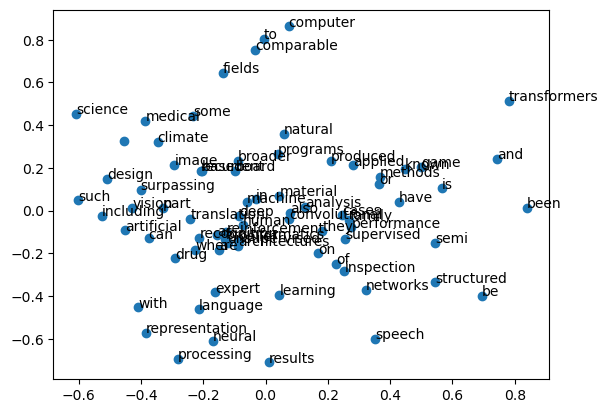

In [16]:
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])  
# Plot the 2D reduced embeddings as points on a scatter plot
# reduced_embeddings[:, 0] represents the x-coordinates
# reduced_embeddings[:, 1] represents the y-coordinates

for i, word in enumerate(index_to_word.values()):  
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))  
    # Annotate each point with its corresponding word from index_to_word
    # 'i' indexes the position, and 'word' is the actual word to display at that position

plt.show()  # Display the plot


In [17]:
# Define a list of sentences for testing
test_sentences = [
    "known as structured learning",
    "transformers have applied to",
    "where they produced results",
    "cases surpassing expert performance"
]

# Loop through each sentence in the test set
for sent in test_sentences:
    test_words = sent.split(" ")  # Split each sentence into individual words
    x_test = []  # Initialize a list to hold the word indices for each word in the sentence

    for i in test_words:
        # Look up the index for each word in word_to_index, defaulting to 0 if the word is not found
        word_index = word_to_index.get(i, 0)
        x_test.append(word_index)  # Add the index to the test input list
    
    # Convert the list of indices to a NumPy array and reshape for the model's input requirements
    x_test = np.array([x_test])

    # Predict the next word using the model
    pred = model.predict(x_test)
    pred = np.argmax(pred[0])  # Get the index of the word with the highest probability

    # Display the original test words and the predicted next word
    print("Input words:", test_words, "\nPredicted next word:", index_to_word.get(pred), "\n\n")


1/1 [==============================] - 0s 195ms/step
pred  ['known', 'as', 'structured', 'learning'] 
= neural 


1/1 [==============================] - 0s 31ms/step
pred  ['transformers', 'have', 'applied', 'to'] 
= been 


1/1 [==============================] - 0s 50ms/step
pred  ['where', 'they', 'produced', 'results'] 
= have 


1/1 [==============================] - 0s 43ms/step
pred  ['cases', 'surpassing', 'expert', 'performance'] 
= human 




In [ ]:
This practical involves building a Word2Vec-like model using a shallow neural network architecture for learning word embeddings and predicting context words from a given target word in a sentence. Below is a comprehensive list of theoretical concepts that an examiner might ask about, covering all aspects of the practical:

### 1. **Word2Vec Overview**
   - **Word2Vec** is a shallow neural network model designed for learning word embeddings, which represent words in a continuous vector space, where semantically similar words are closer together.
   - **Objective**: The model aims to predict the probability of context words given a target word (or vice versa) based on its surrounding context in a large corpus of text.
   - There are two main architectures for Word2Vec:
     - **Continuous Bag of Words (CBOW)**: Given a context (surrounding words), predict the target word.
     - **Skip-gram**: Given a target word, predict the context words.

### 2. **Preprocessing of Text Data**
   - **Tokenization**: Splitting sentences into individual words or tokens. This is typically done using whitespace or punctuation as delimiters.
   - **Text Cleaning**: Removing non-alphanumeric characters (such as special characters or punctuation) to ensure that only relevant words remain.
     - **Regular Expressions (Regex)**: Used to clean and preprocess text (e.g., removing unwanted characters or ensuring only words with alphanumeric characters remain).
   - **Lowercasing**: Ensuring uniformity by converting all words to lowercase.
   - **Stop Words Removal**: In some cases, commonly occurring words (such as "the", "a", "and") are removed to reduce noise.

### 3. **Tokenizer and Word Indexing**
   - **Tokenizer**: Converts sentences or words into sequences of indices. It assigns a unique integer index to each word in the vocabulary.
   - **Word-to-Index Mapping**: A dictionary is created to map each word to a unique index.
   - **Index-to-Word Mapping**: A reverse mapping is created to map indices back to the original words.
   - **OOV (Out-of-Vocabulary) Words**: Words that are not part of the training corpus are assigned a default index (e.g., 0), which is typically treated as an unknown word.

### 4. **Word Embeddings**
   - **Word Embeddings**: A dense vector representation of words, where semantically similar words are closer together in the vector space. This representation captures semantic relationships (e.g., "king" - "man" + "woman" = "queen").
   - **Embedding Layer**: In a neural network, the embedding layer is responsible for converting integer indices into dense word vectors. The weights of this layer are learned during training.
   - **Embedding Dimension**: The size of the vector representing each word. Common dimensions are 50, 100, 200, or 300. Larger dimensions can capture more nuanced relationships but require more data to train effectively.

### 5. **PCA (Principal Component Analysis) for Visualization**
   - **Dimensionality Reduction**: The word embeddings are high-dimensional (e.g., 100 dimensions), which makes it difficult to visualize. PCA is a method used to reduce the dimensionality of these embeddings, typically to 2D or 3D for visualization.
   - **PCA Method**: PCA works by finding the principal components (the directions of maximum variance) in the data and projecting the data onto those components. This results in reduced dimensions while preserving as much variance as possible.

### 6. **Context and Target Words**
   - **Context Window**: In the Skip-gram model, for a given target word, context words are selected within a specific window size. For example, if the window size is 2, two words before and two words after the target word are considered context words.
   - **Target Word**: The central word in a given context, whose surrounding words are used to predict it (in the case of Skip-gram).

### 7. **Shallow Neural Network Architecture**
   - **Architecture**: A simple neural network with:
     - An **Embedding Layer**: Converts each word in the input context to its word vector.
     - A **Dense Layer**: A fully connected layer that processes the word embeddings and learns to predict the target word.
     - The final layer typically uses **softmax** activation to output a probability distribution over all possible words in the vocabulary.
   - **Loss Function**: The loss function used in this task is typically **sparse categorical cross-entropy**, which is appropriate for classification problems where the target variable is a single class index.

### 8. **Training the Model**
   - **Training Data**: The training data consists of pairs of context and target words (pairs of indices). For example, in a sentence "the cat sat on the mat", for a window size of 1, the target word could be "cat", and the context words would be "the" and "sat".
   - **Optimization**: The model is trained using gradient descent (or variants like Adam) to minimize the loss function and update the weights of the model (both the embedding weights and the dense layer weights).
   - **Backpropagation**: The error is propagated back through the network to adjust the weights using the chain rule of derivatives.

### 9. **Prediction Using the Model**
   - **Inference**: After training, the model can be used to predict the next word in a sequence, given the context.
   - **Softmax Layer**: The output layer generates a probability distribution for all words in the vocabulary. The word with the highest probability is predicted as the next word.
   - **Decoding the Prediction**: The predicted index is mapped back to the corresponding word using the `index_to_word` dictionary.

### 10. **Evaluation**
   - **Evaluation Metrics**: 
     - **Accuracy**: Measures how often the model’s predictions match the expected results.
     - **Perplexity**: A measure of how well the probability distribution predicted by the model matches the actual distribution of words.
   - **Testing on New Sentences**: The model is tested on new sentences to evaluate how well it generalizes to unseen data.
   - **Visualizing Embeddings**: PCA or t-SNE can be used to visualize the learned embeddings in 2D or 3D, helping to assess if similar words are grouped together.

### 11. **Applications of Word Embeddings**
   - **Semantic Similarity**: Word embeddings capture the meaning of words. Similar words will have similar vector representations (e.g., "king" and "queen").
   - **Analogies**: Word embeddings can be used to solve analogies (e.g., "man" - "woman" + "queen" = "king").
   - **Text Classification**: Word embeddings are often used as input features for downstream tasks like sentiment analysis, document classification, and machine translation.

### 12. **Challenges in Word Embeddings**
   - **OOV Words**: Words that do not appear during training are not represented in the embedding space.
   - **Polysemy**: A single word can have multiple meanings based on context (e.g., "bank" as a financial institution vs. "bank" of a river). Modern models like BERT address this issue by using contextual embeddings.
   - **Biases in Word Embeddings**: Embeddings can capture societal biases present in the training data (e.g., gender, racial biases).

---

### Possible Exam Questions:
- **What is Word2Vec, and how does it work?**
- **Explain the difference between CBOW and Skip-gram.**
- **How do you handle unknown words (OOV) in Word2Vec?**
- **What is the purpose of dimensionality reduction in word embeddings?**
- **How does the softmax function work in the context of this model?**
- **Explain the use of PCA in visualizing word embeddings.**
- **How does the training process of the Word2Vec model work?**
- **What challenges might arise when using Word2Vec, and how can they be mitigated?**

This list provides a comprehensive understanding of the key concepts related to this practical, covering theory and implementation details in word embeddings, neural networks, and natural language processing (NLP).

Here are some additional theoretical questions related to the practical, along with answers to help you prepare:

---

### 1. **What is the role of the `Embedding` layer in the Word2Vec model?**
   - **Answer**: The `Embedding` layer is responsible for converting input word indices into dense vector representations (embeddings). Each word is represented by a unique vector, and these vectors are learned during the training process. This layer maps the discrete indices of words into a continuous vector space, where semantically similar words are located near each other.

---

### 2. **Why is the `Lambda` layer used after the `Embedding` layer?**
   - **Answer**: The `Lambda` layer is used to apply custom operations to the output of the `Embedding` layer. In this case, it performs a **mean** operation (`tf.reduce_mean`) over the context words' embeddings to aggregate the context. This step is crucial for the Skip-gram model, where the context vectors (representing the surrounding words) are averaged to predict the target word.

---

### 3. **Explain the concept of **skip-gram** in Word2Vec.**
   - **Answer**: In the **Skip-gram** model, the objective is to predict the surrounding words (context) given a target word. The model learns to predict context words for a given target word by maximizing the probability of the context words given the target. For instance, for the sentence "The cat sat on the mat," if "cat" is the target word, the model tries to predict "the" and "sat" as the context words.

---

### 4. **What is the `sparse_categorical_crossentropy` loss function used for?**
   - **Answer**: `sparse_categorical_crossentropy` is a loss function used for classification problems where the target values are integers. In this case, the target words (context words) are represented as integers (word indices), and this loss function measures the difference between the predicted probability distribution (output of the model) and the actual word index (target word). It is suitable when the target labels are sparse (i.e., not one-hot encoded).

---

### 5. **Why is `softmax` used in the output layer of the model?**
   - **Answer**: `Softmax` is used in the output layer because it converts the raw output of the network (which can be any real-valued number) into a probability distribution over the entire vocabulary. Each value in the output vector corresponds to the predicted probability of a word being the correct target word, and the sum of all the probabilities equals 1. This makes it ideal for multi-class classification tasks, like predicting the target word.

---

### 6. **Why is PCA used to visualize word embeddings?**
   - **Answer**: Word embeddings are typically high-dimensional (e.g., 100 or 300 dimensions). PCA (Principal Component Analysis) is used to reduce the dimensionality of the embeddings to 2 or 3 dimensions for visualization purposes. By projecting the embeddings onto these two or three principal components, we can plot the word embeddings in a 2D or 3D space, making it easier to understand their relationships and how similar words are clustered together.

---

### 7. **What is the purpose of using `Adam` optimizer in this model?**
   - **Answer**: The `Adam` optimizer is an adaptive optimization algorithm that computes individual adaptive learning rates for each parameter by considering both the first moment (mean) and second moment (uncentered variance) of the gradients. It combines the benefits of two other extensions of stochastic gradient descent (SGD), namely AdaGrad and RMSProp, making it efficient and effective for training models with large datasets and many parameters, like this word embedding model.

---

### 8. **What are some alternatives to Word2Vec for generating word embeddings?**
   - **Answer**:
     - **GloVe (Global Vectors for Word Representation)**: Unlike Word2Vec, which is a predictive model, GloVe is a count-based method that constructs word embeddings by factorizing the word co-occurrence matrix.
     - **FastText**: Developed by Facebook, FastText extends Word2Vec by representing words as bags of character n-grams, which helps handle rare words or out-of-vocabulary words better.
     - **BERT (Bidirectional Encoder Representations from Transformers)**: A deep learning model that generates contextual embeddings for words based on the surrounding text, addressing the issue of polysemy.

---

### 9. **What is the difference between `word2vec` and `GloVe`?**
   - **Answer**: Both Word2Vec and GloVe are popular methods for learning word embeddings. The key differences are:
     - **Word2Vec** is a predictive model that learns word embeddings based on context windows in text using either CBOW or Skip-gram methods.
     - **GloVe**, on the other hand, is a count-based model that factors a word co-occurrence matrix to capture global statistical information about word relationships.

---

### 10. **Explain what `context_size` means in this Word2Vec implementation.**
   - **Answer**: The `context_size` refers to the number of words on each side of the target word that are considered as context words. In this model, for a given target word, a window of words around it is used as the context. For example, if `context_size` is 2, two words before and two words after the target word are used as context.

---

### 11. **How does Word2Vec handle word similarity and analogies?**
   - **Answer**: Word2Vec embeddings are designed in such a way that words with similar meanings are close to each other in the embedding space. This spatial proximity can be quantified using similarity measures like cosine similarity. Word2Vec can also solve analogies (e.g., "king" - "man" + "woman" = "queen") by performing vector arithmetic, where the vector difference between words captures semantic relationships.

---

### 12. **How are out-of-vocabulary (OOV) words handled in this model?**
   - **Answer**: OOV words are handled by assigning them a default index (commonly 0). These words do not have embeddings learned from the training data, so they are treated as unknown during prediction. Some models handle this better by using subword information (e.g., FastText), but in this simple Word2Vec implementation, OOV words are mapped to a special "unknown" token.

---

### 13. **What are the challenges of using Word2Vec in practice?**
   - **Answer**:
     - **Word Sense Disambiguation**: Word2Vec generates a single vector for each word, which means it cannot distinguish between different meanings of the same word (e.g., "bat" as a flying animal vs. "bat" as a sports equipment).
     - **Large Corpus Requirement**: Word2Vec models require large corpora of text to produce meaningful embeddings.
     - **Biases**: Word embeddings can capture societal and cultural biases (e.g., gender or racial biases) present in the training data.
     - **Out-of-Vocabulary Words**: Words that don't appear in the training corpus are not represented by the model, leading to a limitation in real-world applications.

---

### 14. **What role does the activation function play in the dense layers?**
   - **Answer**: The activation functions introduce non-linearity into the model, which allows it to learn complex relationships in the data. In this model:
     - **ReLU (Rectified Linear Unit)** is used in the hidden layers to help the model learn complex patterns by activating only positive values, promoting sparsity.
     - **Softmax** is used in the output layer to turn the raw scores into probabilities and to ensure that the sum of the probabilities is 1, making it suitable for classification.

---

By covering these theoretical points, you should be well-prepared for an exam or interview about this Word2Vec-like model implementation. Let me know if you'd like to explore any specific area in more detail!